In [133]:
from cbir_helpers import gen_descriptors, match_images
from file_processing import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [134]:
import importlib
import cbir_helpers
importlib.reload(cbir_helpers)

<module 'cbir_helpers' from '/srv/app/cbir_helpers.py'>

In [164]:
def analyse_wrong_threshold(correct, wrong, all_invalid_dists=None):
    data = {}
    for i in range(50, 230, 10):
        perc_correct_missed = len([d for d in correct if d>i])/len(correct)
        perc_wrong_admitted = len([d for d in wrong if d<i])/len(wrong)
        data[str(i)] = [perc_correct_missed, perc_wrong_admitted]
        columns = ['perc_correct_missed','perc_wrong_admitted']
        if all_invalid_dists is not None:
            perc_invalid_admitted = len([d for d in all_invalid_dists if d<i])/len(all_invalid_dists)
            data[str(i)].append(perc_invalid_admitted)
            columns.append('perc_invalid_admitted')
    
    data_df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
    display(data_df.plot())
    
    data = {}
    for i in range(50, 160, 10):
        count_correct_missed = len([d for d in correct if d>i])
        count_wrong_admitted = len([d for d in wrong if d<i])
        data[str(i)] = [count_correct_missed, count_wrong_admitted]
        columns = ['count_correct_missed', 'count_wrong_admitted']
        if all_invalid_dists is not None:
            count_invalid_admitted = len([d for d in all_invalid_dists if d<i])
            data[str(i)].append(count_invalid_admitted)
            columns.append('count_invalid_admitted')
    data_df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
    display(data_df.plot())

In [135]:
dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed_multiple_hold_imgs_small_with_invalid/'
dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed_multiple_hold_imgs_small_with_invalid/'
DETECTOR_TYPE = 'orb'
NO_CATS = 47
NO_FEATURES = 450
GREY = True

In [136]:
descriptors = cbir_helpers.gen_descriptors(dataset_path, DETECTOR_TYPE, NO_CATS, NO_FEATURES, GREY)

Time elapsed generating descriptors: 11.121401071548462


In [137]:
d = cbir_helpers.match_images('BF', descriptors)

Time elapsed matching all images: 318.8511061668396


In [151]:
cbir_helpers.get_stats(d)

Max correct: 210.0
Min wrong: 82.0
Total number of images: 363
Number wrong: 22
Number wrong below threshold: 21
% wrong below max correct: 6.0%
% wrong overall: 6.0%
% wrong overall top 3: 5.0%


In [152]:
d_wo_invalid = {k:v for k,v in d.items() if k.split('/')[0] != str(47)}

In [153]:
min_dists = cbir_helpers.get_min_dists(d_wo_invalid)

In [167]:
correct, wrong = cbir_helpers.find_correct_wrong_dists(min_dists)

In [168]:
max(correct)

137.0

In [169]:
min(wrong)

82.0

In [157]:
def find_correct_wrong_all_matches(d):
    correct_dists = []
    wrong_dists = []
    for img, matches in d.items():
        correct_c = img.split('/')[0]
        for img2, dist in matches.items():
            img2_c = img2.split('/')[0]
            if correct_c == img2_c:
                correct_dists.append(dist)
            else:
                wrong_dists.append(dist)
    return correct_dists, wrong_dists

In [158]:
correct_dists, wrong_dists = find_correct_wrong_all_matches(d_wo_invalid)

But here the bias is that a lot of those "correct" matches are from images that look quite different. 

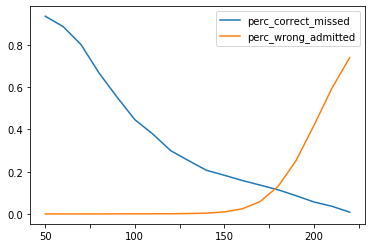

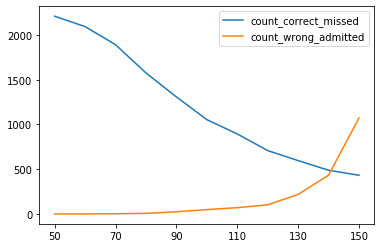

In [165]:
analyse_wrong_threshold(correct_dists, wrong_dists)

In [85]:
def invalid_images_stats(d):
    max_valids = []
    min_invalids = []
    all_invalid_dists = []
    for img, dists_d in d.items():
        if img.split('/')[0]!=str(47):  # we want to skip the bad images
            valid_dists = []
            invalid_dists = []
            for imgname, dist in dists_d.items():
                c = imgname.split('/')[0]
                if int(c)<47:
                    valid_dists.append(dist)
                else:
                    invalid_dists.append(dist)
                    all_invalid_dists.append(dist)
            max_valids.append(max(valid_dists))
            min_invalids.append(min(invalid_dists))
    return max_valids, min_invalids, all_invalid_dists

In [87]:
max_valids, min_invalids, all_invalid_dists = invalid_images_stats(d)

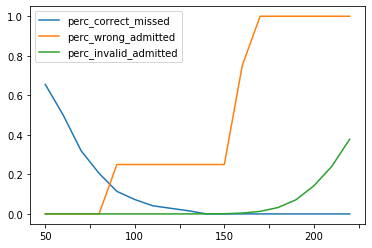

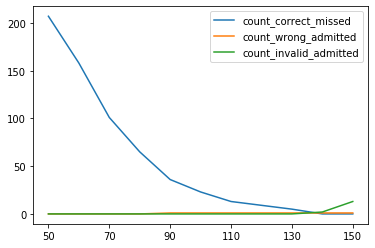

In [166]:
analyse_wrong_threshold(correct, wrong, all_invalid_dists)

#### The tradeoff really is between missed correct _first_ matches and admitted _any_ (or top three) wrong matches

To do: plot missing first best matches against admitting wrong preds in top 3

In [176]:
t = 137

In [177]:
len([d for d in correct if d>t])/len(correct)

0.0

In [178]:
len([d for d in wrong_dists if d<t])/len(wrong_dists)

0.0030754859972858175

From this, I conclude that non match threshodl should be 137, to maximise correct matches and this only admits 1 wrong match with valid images and 1 wrong match with invalid. 

### Test set (Yonder)

The steps would be to match with Yonder and I would expect to see few incorrect matches under 137, and get all correct matches. 

However I know that images from Yonder are a bit different...

In [118]:
dataset_path = 'data/categories_yonder_cbir_small'
DETECTOR_TYPE = 'orb'
NO_CATS = 38
NO_FEATURES = 450
GREY = True

In [119]:
descriptors = cbir_helpers.gen_descriptors(dataset_path, DETECTOR_TYPE, NO_CATS, NO_FEATURES, GREY)

Time elapsed generating descriptors: 2.634906053543091


In [120]:
len(list(descriptors.keys()))

137

In [121]:
d = cbir_helpers.match_images('BF', descriptors)

Time elapsed matching all images: 30.658841609954834


In [122]:
cbir_helpers.get_stats(d)

Max correct: 141.0
Min wrong: 51.0
Total number of images: 137
Number wrong: 21
Number wrong below threshold: 21
% wrong below max correct: 15.0%
% wrong overall: 15.0%
% wrong overall top 3: 3.0%


In [123]:
min_dists = cbir_helpers.get_min_dists(d)

In [124]:
correct, wrong = cbir_helpers.find_correct_wrong_dists(min_dists)

In [125]:
max(correct)

141.0

In [132]:
[c for c in correct if c > 137]

[141.0]

In [126]:
min(wrong)

51.0

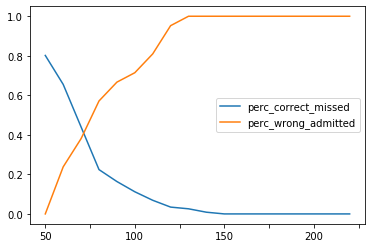

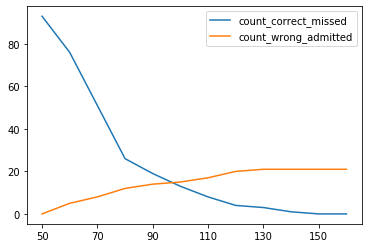

In [129]:
analyse_wrong_threshold(correct, wrong)

For this dataset the threshold does not remove any wrong matches. But I know that those "wrong" matches are because that hold physically appeared in the another route's image. So you cant' blame it. 

On the correct side, only 1 correct match is prevented - not too bad.